### Importing libraries

In [24]:
import os
import pandas as pd
import re
from glob import glob
import matplotlib.pyplot as plt

### Create a combined dataframe for all 6 years and months June-September

In [ ]:
# Define valid month indicators (case insensitive)
VALID_MONTHS = ["jun", "jul", "aug", "sep"]

# Root data folder
root_folder = "rf data"
all_dataframes = []

# Function to detect file type based on preview of first 40 rows
def detect_file_type(file_path):
    try:
        preview_df = pd.read_excel(file_path, header=None, nrows=40, sheet_name="Sheet1", engine="xlrd")

        flat_values = preview_df.fillna("").astype(str).values.flatten()
        flat_values = [v.strip().lower() for v in flat_values]

        # Check if any cell contains "met. subdivision"
        if any("met. subdivision" in v for v in flat_values):
            # Check if it contains "met. subdivision: <some name>"
            if any("met. subdivision:" in v for v in flat_values):
                return 1  # File Type 2
            else:
                return 2  # File Type 1
        else:
            return None  # Unknown file type

    except Exception as e:
        print(f"Error detecting file type for {file_path}: {e}")
        return None

# Function to process File Type 1
def parse_file_type_1(file_path, year, month_str):
    try:
        df_raw = pd.read_excel(file_path, header=None, sheet_name="Sheet1", engine="xlrd")
        parsed_rows = []

        current_district = None
        current_subdivision = None

        for idx, row in df_raw.iterrows():
            row_values = row.dropna().astype(str).tolist()
            if not row_values:
                continue  # skip empty rows

            # Detect subdivision
            if str(row[0]).strip().upper().startswith('MET. SUBDIVISION'):
                current_subdivision = str(row[0]).split(':')[-1].strip().upper()
                continue

            # Detect district
            if str(row[0]).strip().upper().startswith('DISTRICT'):
                current_district = str(row[0]).split(':')[-1].strip().upper()
                continue

            # Detect valid station data row
            if len(row) >= 37 and current_district and current_subdivision:
                station = str(row[0]).strip()
                rain_data = row[1:32].tolist()
                total_rf = row[32]
                rainy_days = row[33]
                cris_id = row[34]
                lat = row[35]
                lon = row[36]

                for day, rainfall in enumerate(rain_data, start=1):
                    try:
                        date = pd.to_datetime(f"{year}-{month_str.title()}-{day:02d}", errors='coerce')
                    except:
                        date = None

                    if pd.notna(date):
                        parsed_rows.append({
                            'Year': year,
                            'District': current_district,
                            'Met_Division': current_subdivision,
                            'Station': station,
                            'Date': date,
                            'Rainfall': rainfall,
                            'Total': total_rf,
                            'Rainy_Days': rainy_days,
                            'CRIS_ID': cris_id,
                            'LAT_DM': lat,
                            'LONG_DM': lon
                        })

        return pd.DataFrame(parsed_rows) if parsed_rows else None

    except Exception as e:
        print(f"Error parsing Type 1 file {file_path}: {e}")
        return None

# Function to process File Type 2
def parse_file_type_2(file_path, year, month_str):
    try:
        df = pd.read_excel(file_path, header=None, sheet_name="Sheet1", engine="xlrd")

        # Detect the header row with both 'district' and 'subdivision'
        data_start_idx = df[df.apply(
            lambda row: row.astype(str).str.lower().str.contains("district").any() and
                        row.astype(str).str.lower().str.contains("met. subdivision").any(),
            axis=1
        )].index[0]

        # Load again with correct headers
        df = pd.read_excel(file_path, header=data_start_idx, sheet_name="Sheet1", engine="xlrd")
        df = df.iloc[:, :33]  # district, subdivision, days 1–31

        df = df[df.iloc[:, 0].notna()]  # remove empty district rows
        df.columns = ['District', 'Met_Subdivision'] + [f"{day:02d}" for day in range(1, 32)]

        # Melt to long format: 1 row per day
        df_long = df.melt(
            id_vars=['District', 'Met_Subdivision'],
            var_name='Day',
            value_name='Rainfall'
        )

        # Add year and month to get full date
        df_long['Year'] = year
        df_long['Month'] = month_str.title()
        df_long['Day'] = df_long['Day'].astype(str).str.zfill(2)
        df_long['Date'] = pd.to_datetime(df_long['Year'].astype(str) + '-' + df_long['Month'] + '-' + df_long['Day'], errors='coerce')

        # Drop rows with invalid dates
        df_long = df_long[df_long['Date'].notna()]

        # Reorder and rename columns
        df_long = df_long.rename(columns={'Met_Subdivision': 'Met_Division'})
        df_long = df_long[['Year', 'District', 'Met_Division', 'Date', 'Rainfall']]

        return df_long

    except Exception as e:
        print(f"Error parsing Type 2 file {file_path}: {e}")
        return None

# Walk through each year folder
year_folders = sorted(glob(os.path.join(root_folder, "*/")))

for year_folder in year_folders:
    year = os.path.basename(os.path.normpath(year_folder))
    xls_files = glob(os.path.join(year_folder, "*.xls"))

    for file_path in xls_files:
        file_name = os.path.basename(file_path).lower()
        if any(month in file_name for month in VALID_MONTHS):
            file_type = detect_file_type(file_path)
            month_str = next((m for m in VALID_MONTHS if m in file_name), None)
            if not month_str:
                print(f"Could not detect month in file name: {file_path}")
                continue

            if file_type == 1:
                parsed_df = parse_file_type_1(file_path, year, month_str)
            elif file_type == 2:
                parsed_df = parse_file_type_2(file_path, year, month_str)
            else:
                print(f"Unknown format, skipping file: {file_path}")
                continue

            if parsed_df is not None:
                all_dataframes.append(parsed_df)

# Combine all
if all_dataframes:
    final_df = pd.concat(all_dataframes, ignore_index=True)
    print("Final dataframe shape:", final_df.shape)
else:
    print("No dataframes parsed correctly.")


Final dataframe shape: (210450, 11)


In [34]:
final_df.to_csv("combined_rainfall_data.csv", index=False)

### Create individual station data

In [37]:
# Load dataset
df = pd.read_csv("combined_rainfall_data.csv")

# Keep relevant columns and drop rows with missing Rainfall
filtered_df = df[['Station', 'Date', 'Rainfall', 'LAT_DM', 'LONG_DM']].dropna(subset=['Rainfall'])

# Convert 'Date' column to datetime format for proper sorting
filtered_df['Date'] = pd.to_datetime(filtered_df['Date'])

# Save the full filtered dataset sorted by Date
filtered_df = filtered_df.sort_values(by='Date')
filtered_df[['Station', 'Date', 'Rainfall']]

# Create a directory to store individual station files
output_dir = "per_station_data"
os.makedirs(output_dir, exist_ok=True)

# Group by station and save separate CSVs
for station, group_df in filtered_df.groupby('Station'):
    lat_dm = group_df['LAT_DM'].iloc[0]
    long_dm = group_df['LONG_DM'].iloc[0]
    
    # Create safe filename
    safe_station = station.replace(" ", "_").replace("/", "_").replace("\\", "_")
    filename = f"{safe_station}_{lat_dm}_{long_dm}.csv"
    filepath = os.path.join(output_dir, filename)
    
    # Sort each station's data by Date before saving
    group_df = group_df.sort_values(by='Date')
    group_df[['Date', 'Rainfall']].to_csv(filepath, index=False)

print(f"✅ Saved all station-wise CSVs in '{output_dir}' with LAT_DM and LONG_DM in filenames.")

✅ Saved all station-wise CSVs in 'per_station_data' with LAT_DM and LONG_DM in filenames.


### Visualizing 

<>:2: SyntaxWarning: invalid escape sequence '\A'
<>:2: SyntaxWarning: invalid escape sequence '\A'
C:\Users\Shubham\AppData\Local\Temp\ipykernel_36672\2749819775.py:2: SyntaxWarning: invalid escape sequence '\A'
  df = pd.read_csv("per_station_data\AHMEDNAGAR_-_IMD_PT_1905.0_7448.0.csv")


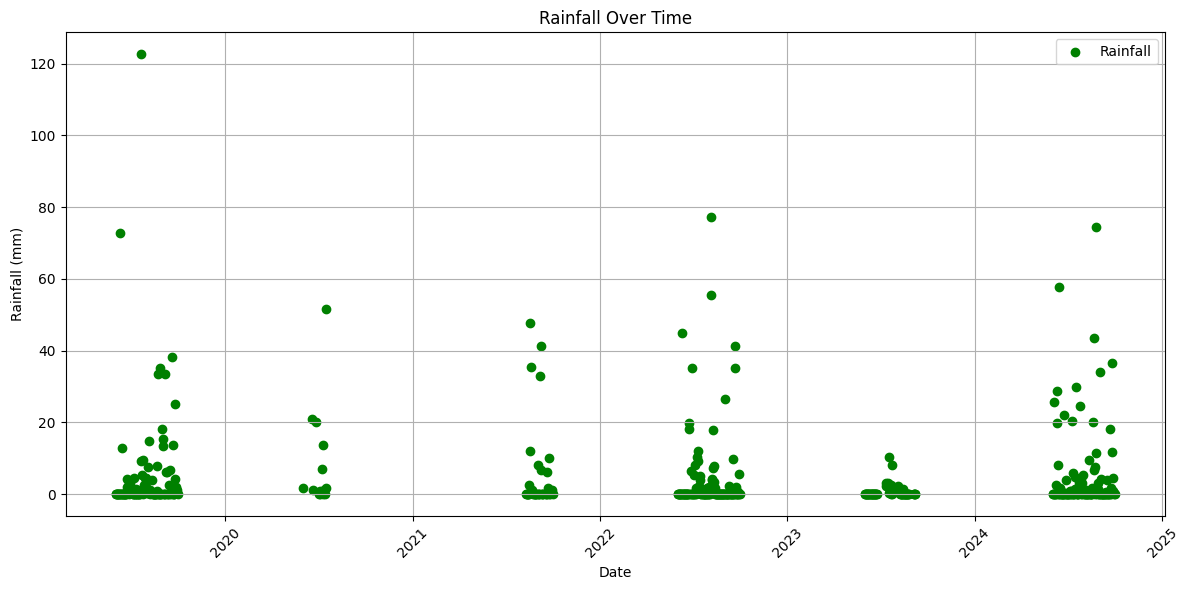

In [38]:
# Load the CSV file
df = pd.read_csv("per_station_data\AHMEDNAGAR_-_IMD_PT_1905.0_7448.0.csv")

# Ensure the 'Date' column is in datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Plot the data
plt.figure(figsize=(12, 6))
plt.scatter(df['Date'], df['Rainfall'], marker='o', color='green', label='Rainfall')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Rainfall (mm)')
plt.title('Rainfall Over Time')
plt.grid(True)
plt.legend()

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()